# 项目：细分客户群体

## 背景分析

这是一家给不同商家提供不同种类产品的批发商。

数据的产生源自该企业大型的销售数据库。

该数据涉及到不同客户在不同类别商品的消费金额。

在传统的企业中，很多决策仅能依靠经验而定，而个人经验往往是有限且不可靠的，如果能通过对数据进行分析，以更智能化的方式代替传统的凭感觉决策，则能更有效的帮助企业充分利用资源，有效节约成本，提高效率，实现营收。通过数据分析实现精细化管理/运营则是有效的手段之一。


## 目标分析
1. 了解不同类别商品间的销售关系：
    分析两两商品间的相关程度，找出相关程度最大的商品类别

2. 实现精细化管理/运营：
    通过对客户进行细分，找出不同类型客户间的差异，进而可对不同用户群体(批发商)实施不同服务方案（如：配送服务，营销策略等）以满足客户需求。

————————————————————————————————————————————————————
### DATA

Data source: UCI Machine Learning Repository-->https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Attribute Information:

* (1) FRESH: annual spending (m.u.) on fresh products (Continuous); 
* (2) MILK: annual spending (m.u.) on milk products (Continuous); 
* (3) GROCERY: annual spending (m.u.)on grocery products (Continuous); 
* (4) FROZEN: annual spending (m.u.)on frozen products (Continuous) 
* (5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
* (6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
* (7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal) 
* (8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal) 

## 一. 数据加载及探索

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display 

import visuals as vs
import seaborn as sns
%matplotlib inline

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True) # 对于此项目，将重点分析记录的六个产品类别，因此忽略特征 'Channel' 和 'Region'，
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


### 1. 观察数据集的统计学描述内容&探索缺失值

In [2]:
# Display a description of the dataset
display(data.describe())
data.isnull().any()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Fresh               False
Milk                False
Grocery             False
Frozen              False
Detergents_Paper    False
Delicatessen        False
dtype: bool

数据集由 6 个重要的产品类别构成：“Fresh”、“Milk”、“Grocery”、“Frozen”、“Detergents_Paper”和“Delicatessen”（生鲜，牛奶，食品杂货，冷冻，清洁用品和纸张，熟食）。

各特征中值与均值差距较大，初步推断是偏态分布数据。

### 2. 进行数据相关性探索

### 2.1 可视化特征分布
为了更好的理解数据集，更直观的观察数据分布情况及特征间关系，画出散布矩阵图。

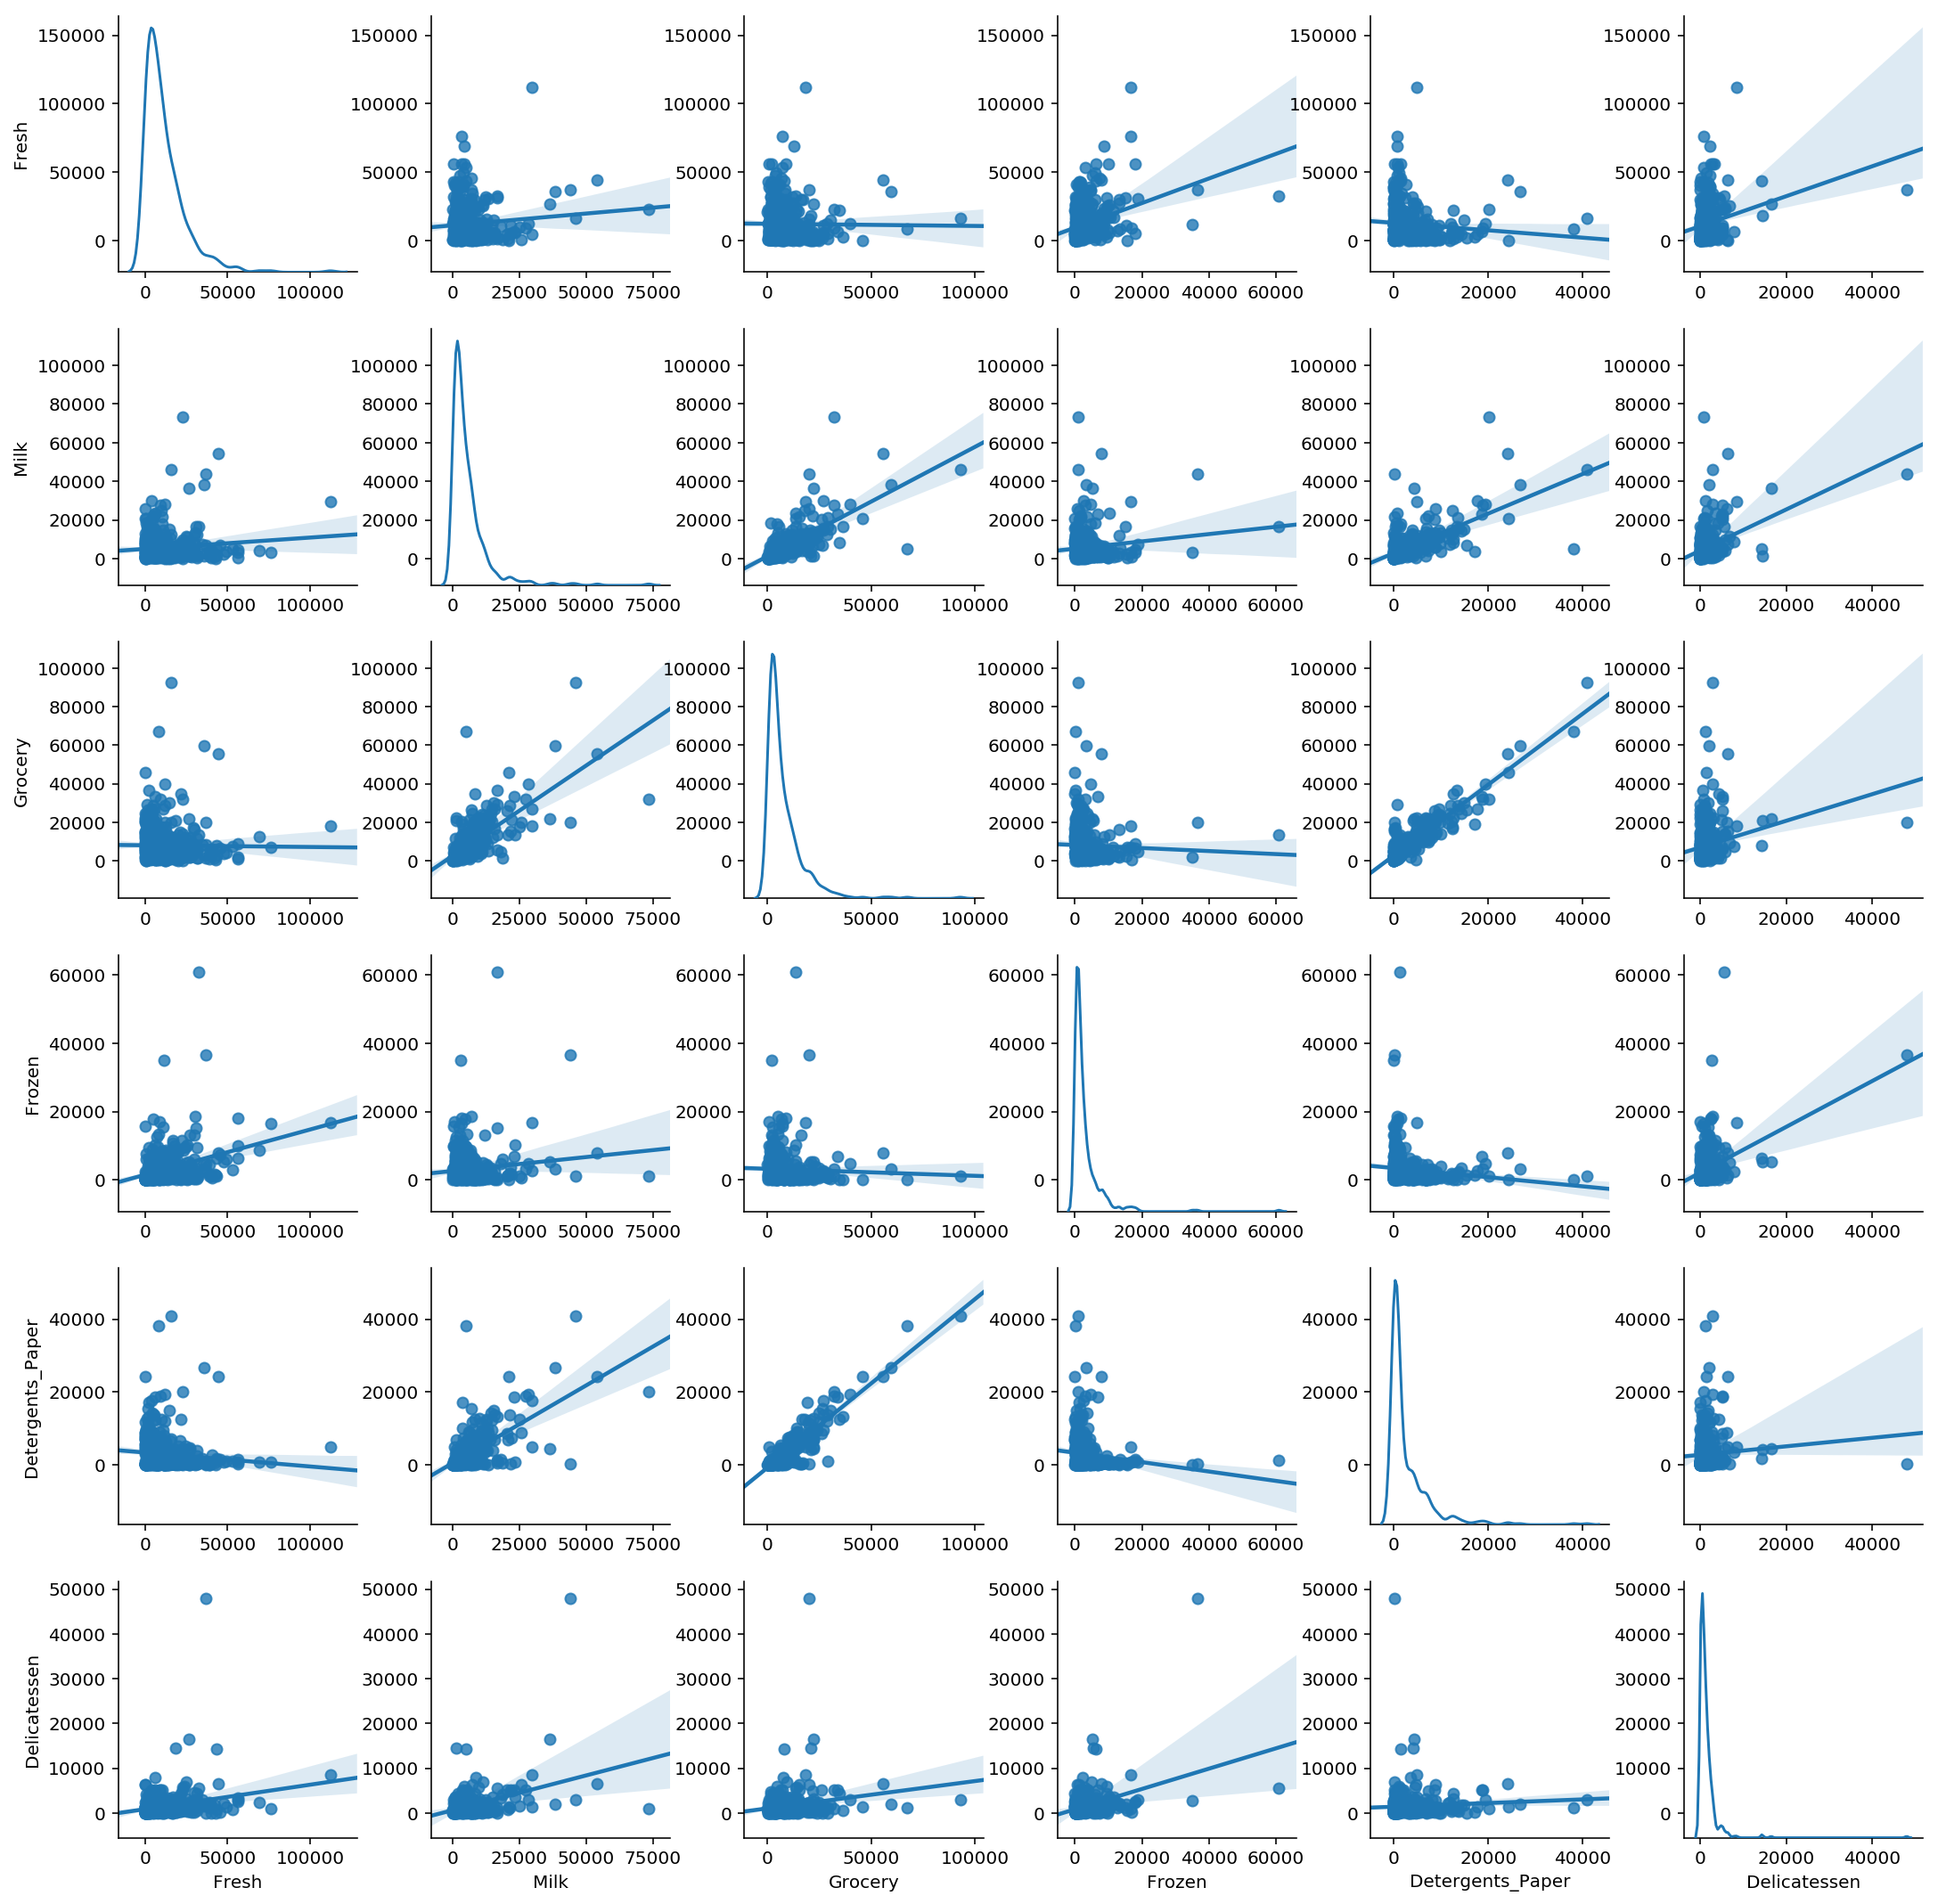

In [34]:
sns.pairplot(data, diag_kind = 'kde', kind="reg") 

通过画散布矩阵图，可以观察到各特征呈严重右偏态分布；

同时可以观察到特征两两间的关系，某些特征对存在类线性的关系。相关性较大的特征对有：食品杂货与牛奶，食品杂货与清洁用品，清洁用品与牛奶。

为了进一步了解特征对的相关性，接着画出特征关系的热图，并标上相关性程度值，更直观的证明了以上的观察结果。

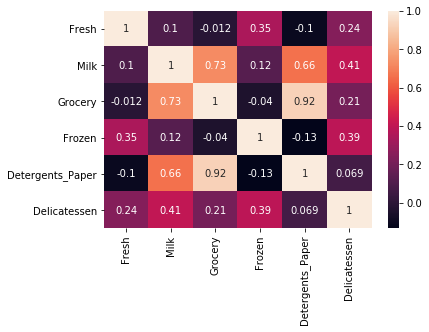

In [19]:
# 使用热力图可视化特征间的关系，以进一步获得信息。
sns.heatmap(data.corr(), annot=True)

通过data.corr()的热力图可以看出： 'Grocery'和'Detergents_Paper'相关性达到0.92，'Grocery'和'Milk'相关性为0.73，'Detergents_Paper'和'Milk'相关性为0.66。 证实这三个特征对是相关性前三的特征对。

### 2.2 特征相关性探索（通过回归进行预测）
* 为了进一步判断客户购买某个类别产品时是否会对其他商品的购买额产生影响。
* 预测特征选择：通过上一步观察中可知道，食品杂货和牛奶,清洁用品存在很大的相关性。因此选择通过牛奶和清洁用品预测食品杂货的购买额。
* 通过训练监督式回归学习器，使用其他特征去预测某一个特征，再进行模型评分，则可判断这个特征与其他特征间的关系。

In [20]:
y_data = data['Grocery']
x_data = data[['Milk', 'Detergents_Paper']]

# Split the data into training and testing sets(0.25) using the given feature as the target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

# Create a liear regressor and fit it to the training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)  

# Returns the coefficient of determination R^2 of the prediction. 
# R^2 [0, 1], 越接近1说明拟合效果越好，越呈线性相关
print(score)

0.778298552353


结果：

R^2 得分为0.778，接近0.8，相对来说是个比较高的得分。

说明可以通过牛奶和清洁用品预测食品杂货的购买额，即牛奶和清洁用品的销量增加的时候，就需要考虑是否该增加食品杂货的库存了，因为往往这时候食品杂货的销量也会增加。

## 二. 数据预处理

### 1. 选择样本
为了更好地通过分析了解客户以及他们的数据会如何变化，最好的方式是选择几个样本数据点并更详细地分析这些数据点。

选择了10，22和85的样本点。因为“10”：在Grocery上的消费较高；“22”:在Fresh上的消费较高；“85”：在多个类别的消费额都较高。

In [3]:
indices = [10, 22, 85]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,3366,5403,12974,4400,5977,1744
1,31276,1917,4469,9408,2381,4334
2,16117,46197,92780,1026,40827,2944


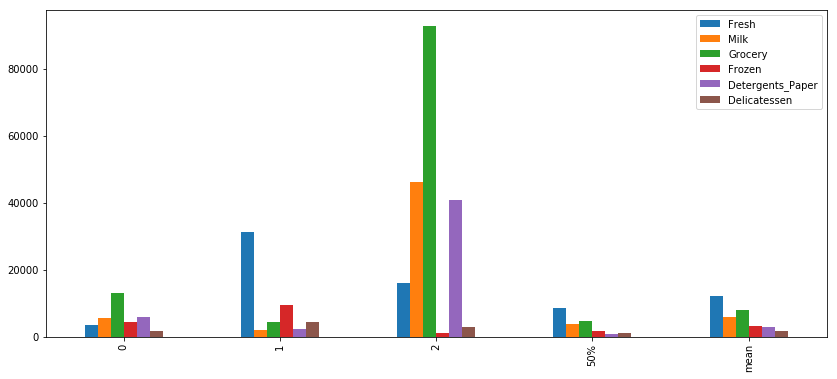

In [4]:
# 画一张柱状图去观察每个客户的购买数量并附上需要的统计信息（比如中位数和平均值），能够直观的进行比较。
samples_bar = samples.append(data.describe().loc['50%'])
samples_bar = samples_bar.append(data.describe().loc['mean'])
samples_bar.plot(kind='bar', figsize=(14,6))

### 2. 特征缩放
从前面的观察可知数据呈现严重的右偏态分布，数据间的差异较大，为了防止对算法造成不良影响，通过log对数转换的方法可以缩小特征的值范围，把数据间差异变小，使数据分布更接近正态分布。

画出转换后数据的散布矩阵图，对转换后的数据进行观察。

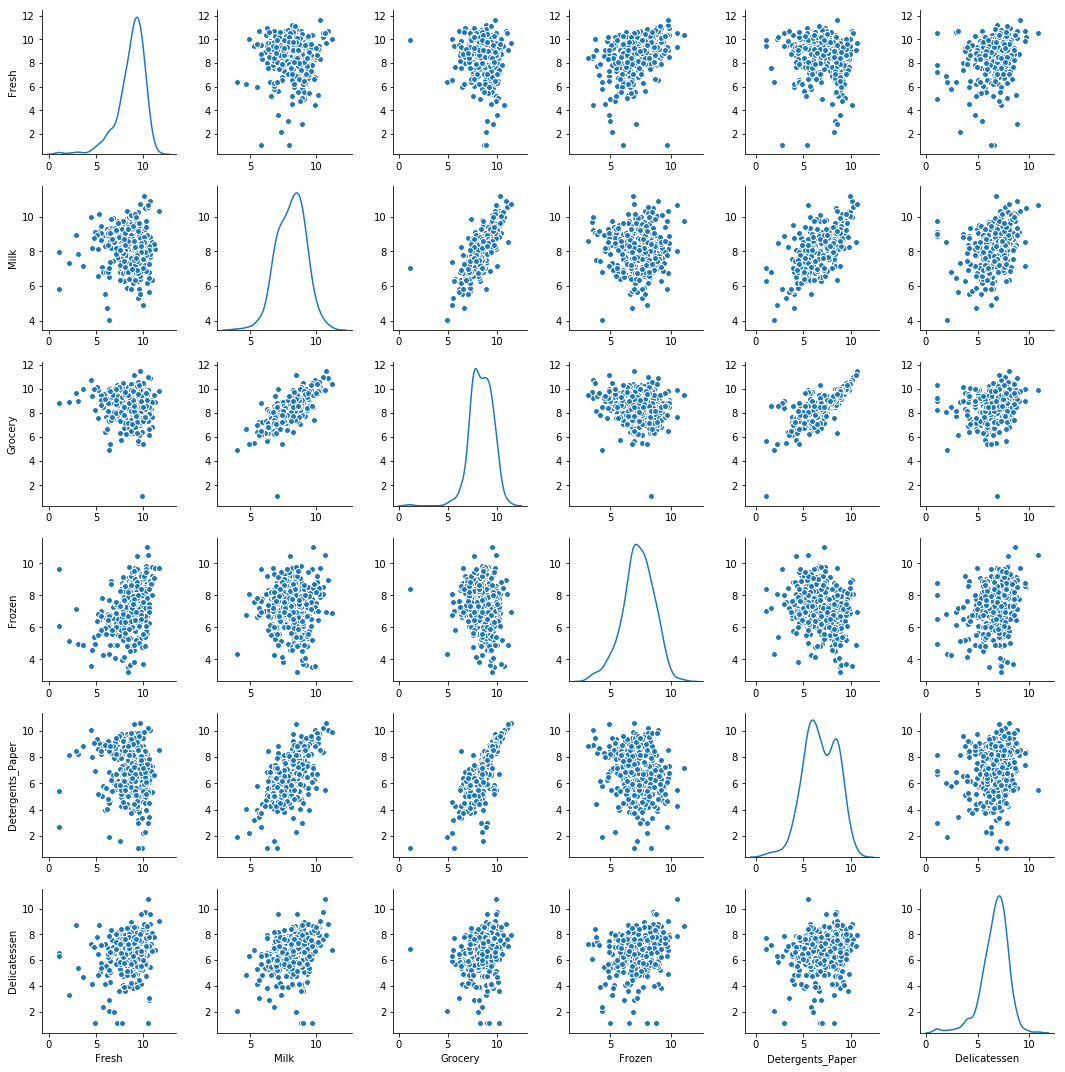

In [5]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# cale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
#pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
sns.pairplot(log_data, diag_kind = 'kde')

** 观察 **

在应用对数转换后样本数据有何变化

In [6]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.121480,8.594710,9.470703,8.389360,8.695674,7.463937
1,10.350606,7.558517,8.404920,9.149316,7.775276,8.374246
2,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524


### 3. 检测离群值

离群值会对结果造成不利影响，特别是对K-Means这样的聚类算法，它对离群值敏感，离群值会影响中心点的移动方向。因此需要删除一定的离群值。但只删除在多个特征中都属于离群值的数据点。如果把在一个特征上的离群值都删了，会删除比例较大的数据，对整体数据会有影响，所以可以删除在两个及两个以上特征为离群值的数据。

计算方法：
计算超过1.5倍四分位距来得出离群值。

In [7]:
# For each feature find the data points with extreme high or low values
outliers = []
for feature in log_data.keys(): # log_data.columns
    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)
    
    print ("Data points considered outliers for the feature '{}':".format(feature)) 
    
    bad_data = log_data[~((log_data[feature] <= Q3 + step) & (log_data[feature] >= Q1 - step))]
    
    outliers.extend(bad_data.index.tolist()) # outliers为list类型，存放异常值的index
    
    display(bad_data)
    
outliers = [x for x in list(set(outliers)) if outliers.count(x)>=2]
print(np.sort(outliers).tolist())

good_data = log_data.drop(outliers, axis=0).reset_index(drop=True) 

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


[65, 66, 75, 128, 154]


### 4. 使用PCA进行主成分分析并进行降维

减少噪音，去除不重要成分；
把复杂问题简单化；
使算法效果更好。

通过之前特征分析，发现某些特征可以通过其他特征预测得到，说明特征中可能存在不重要成分。利用主成分分析 (PCA) 得出批发客户数据的基本结构。因为对数据集使用 PCA 会计算哪些维度最适合最大化方差，可以发现哪些特征组合最能描述客户消费情况。

现在数据已经缩放为更正态的分布，并且删除了任何需要删除的离群值，现在可以向 good_data 应用 PCA，以发现哪些数据维度最适合最大化所涉及的特征的方差。

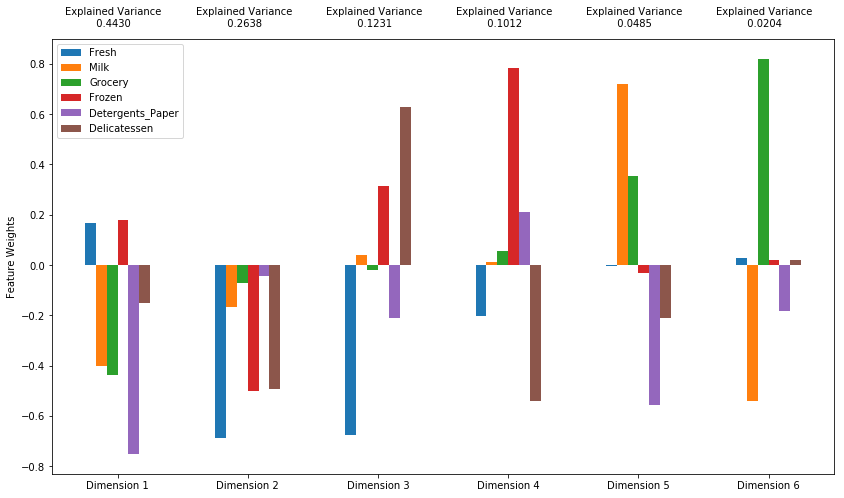

In [8]:
# Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

特定维度的正增长对应的是正加权特征的增长以及负加权特征的降低。增长或降低比例由具体的特征权重决定。

以第一个维度举例，当它的权重正向增长时，它更可能购买 Fresh 和 Frozen ，购买 Milk，Grocery 和 Detergents Paper 的可能性更小，但如果它第一维度的权重是负向增长的，比如增长-0.5，情况则相反。

如果再看第二个维度，假设有一个客户第二个维度的负权特征很大，甚至比第一个维度还大，那么它就是一个对Fresh、Frozen和Delicatessen需求很大的客户。

前两个成分的累积方差为：0.4430+0.2638=0.7068

前四个成分的累积方差为：0.4430+0.2638+0.1231+0.1012=0.9311


** 观察 **

经过对数转换的样本数据在六维空间里应用 PCA 转换后有何变化？

In [9]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))


,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.0887,-0.7006,0.8537,1.0105,-0.5587,0.2495
1,-0.1419,-2.7722,0.3293,0.3928,-1.3904,0.2012
2,-5.3316,-1.8845,-0.6957,-0.1972,0.5461,0.3802


### 实现：降维
在使用主成分分析时，主要目标之一是降低数据维度，以便降低问题的复杂度。降维有一定的代价：使用的维度越少，则解释的总方差就越少。因此，为了了解有多少个维度对问题来说是必要维度，*累积可解释方差比*显得极为重要。此外，如果大量方差仅通过两个或三个维度进行了解释，则缩减的数据可以之后可视化。

In [10]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

** 观察 **

经过对数转换的样本数据在仅使用二个维度并应用 PCA 转换后有何变化？

通过PCA转换后的6维度和2维度的数据点数值相同。

In [11]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.0887,-0.7006
1,-0.1419,-2.7722
2,-5.3316,-1.8845


通过观察，前两个维度的值与六维空间里的 PCA 转换相比没有变化，说明降到2维不会造成太大的信息丢失。


#### 可视化双标图
双标图是一种散点图，每个数据点由主成分上的分数表示。坐标轴是主成分（在此图中是 `Dimension 1` 和 `Dimension 2`）。此外，双标图显示了原始特征沿着成分的投影情况。双标图可以帮助我们解释降维数据，并发现主成分与原始特征之间的关系。


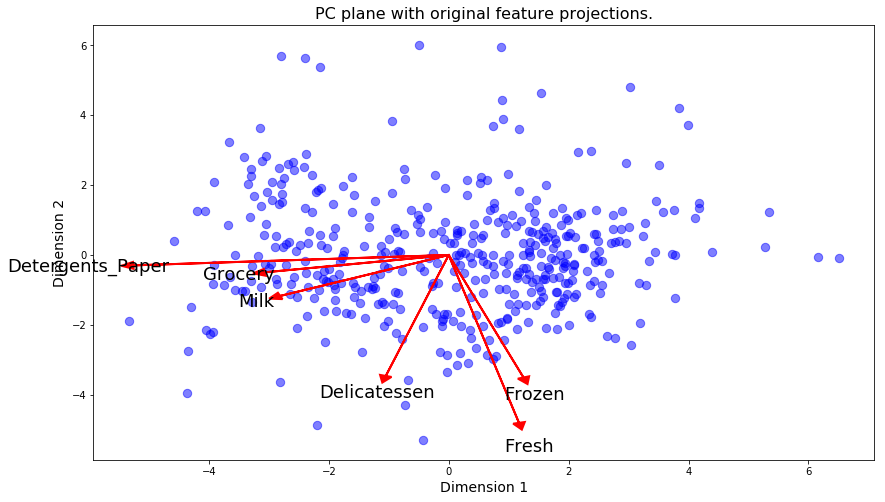

In [12]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

## 三. 构建聚类模型

### 1. 模型选择及评估

#### 1.1 模型选择
K-Means和GMM都是非监督学习的聚类算法，都可对没有标签的数据进行分类.

K-Means：
1. 适用于均匀分布的数据，因为在计算距离时，它会平等的对待所有属性特征
2. 计算量不大，收敛快

GMM:
1. 适用于符合高斯分布的数据
2. 软聚类，适用同一数据可能属于多类别的情况
3. 聚类灵活（一个类可以包含另一个类）

基于K-Means和GMM的特点，现选择这两种算法进行评估比较，最终选择表现最好的那个。

#### 1.2 模型评估/K值确定
使用轮廓系数对聚类进行个数K值的确定以及模型的评估。

如果无法根据先验判断聚类的数量，则无法保证给定的聚类数量能够以最佳方式细分数据，因为不清楚数据存在什么样的结构。但是，我们可以根据每个数据点的轮廓系数进行量化。数据点的轮廓系数会衡量数据点与所分配的聚类之间的相似度，程度用 -1（不相似）到 1（相似）表示。计算均值轮廓系数是对给定聚类进评分的简单方法。

In [15]:
# K-Means 
for n in range(2,7):
    clusterer = model(n_clusters = n, random_state = 40).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    sample_preds = clusterer.predict(pca_samples)
    centers = clusterer.cluster_centers_
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print("clusters: {}, silhouette_score: {}.".format(n, score))

clusters: 2, silhouette_score: 0.42628101546910846.
clusters: 3, silhouette_score: 0.39641738719668546.
clusters: 4, silhouette_score: 0.3323940323950923.
clusters: 5, silhouette_score: 0.33901706934498804.
clusters: 6, silhouette_score: 0.3551540910370931.


In [14]:
# GaussianMixture
for i in range(2,7):
    clusterer = GaussianMixture(n_components=i, random_state=40).fit(reduced_data)
    preds = cluterer.predict(reduced_data)
    centers = clusterer.means_
    sample_preds = clusterer.predict(pca_samples)
    score = silhouette_score(reduced_data, preds)
    print("components: {}, silhouette_score: {}.".format(i, score))

components: 2, silhouette_score: 0.42191684646261496.
components: 3, silhouette_score: 0.37553218893793083.
components: 4, silhouette_score: 0.2484211765665708.
components: 5, silhouette_score: 0.2852368106836713.
components: 6, silhouette_score: 0.31689180723258703.


### 2. 模型构建及可视化
通过观察比较上面的结果，可以看到对于KMeans和GMM来说当把客户分为2类的时候，它们轮廓系数得分是最高的，分别是0.4262和0.4219，而在这两个得分种KMeans的得分又稍高于GMM，因此最终采样KMeans构建聚类模型，并且分类个数K为2。

模型构建好后，再可视化最终的聚类，以不同颜色代表不同的类别，叉则代表之前选择的样本点所在的位置。

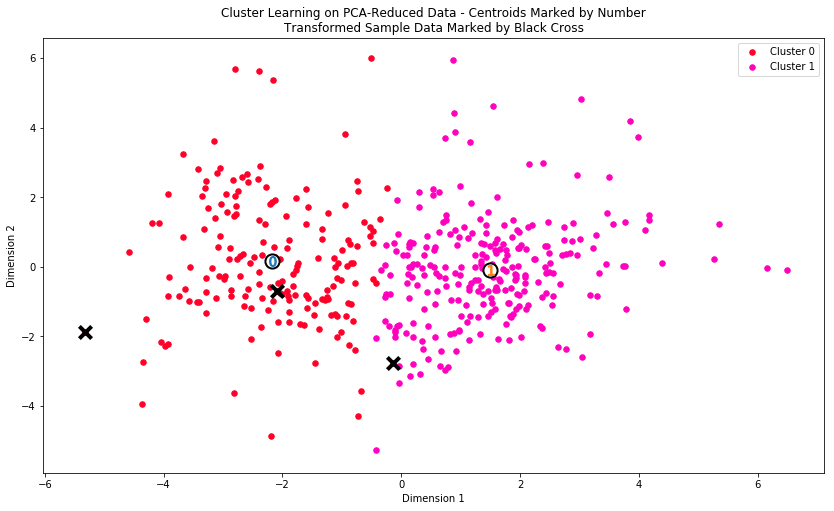

In [17]:
n = 2
clusterer = KMeans(n_clusters = n, random_state = 40).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_

sample_preds = clusterer.predict(pca_samples)
score = silhouette_score(reduced_data, preds)

# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

## 四. 数据恢复
为了进一步分析，获取每个聚类代表性客户的数据，因此进行数据恢复。

由于数据目前是降维状态，且进行了对数缩放，所以需要通过逆转换还原数据。
这些代表性客户，可以通过聚类的中心点得到，这些中心点（或均值）并不是来自数据中特定的点，而是相应聚类的所有数据点的平均值。

In [19]:
# 使用 pca.inverse_transform 对 centers 应用逆转换
log_centers  = pca.inverse_transform(centers)

# 使用 np.exp 对 log_centers 应用 np.log 的逆函数
true_centers = np.exp(log_centers)

true_centers = pd.DataFrame(np.round(true_centers), columns=data.columns)
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4005.0,7900.0,12104.0,952.0,4561.0,1036.0
1,8867.0,1897.0,2477.0,2088.0,294.0,681.0


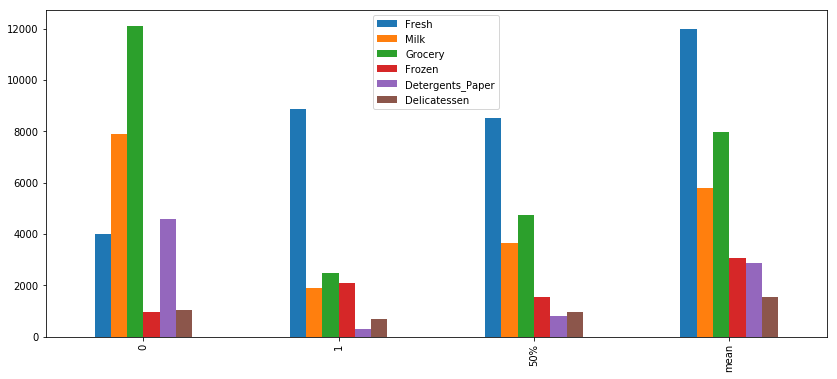

In [20]:
true_centers = true_centers.append(data.describe().loc['50%'])
true_centers = true_centers.append(data.describe().loc['mean'])
true_centers.plot(kind='bar', figsize=(14,6))

通过每类代表性客户在不同产品间的消费额度，可以得到：

第一类客户在milk(牛奶)，Grocery(食品杂货)，Detergents_Paper(清洁用品和纸张）上的消费比较多，以咖啡店为代表；

第二类客户则是在Fresh（生鲜）和Frozen（冷藏）上的消费金额较多。